# Генерация заголовков научных статей

### Импорт модулей и задание случайных начальных чисел для воспроизводимости.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time

c:\Users\denis\anaconda3\envs\python_3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torchtext
import platform

print(f'Версия Python: {platform.python_version()}')
print(f'Платформа: {platform.platform()}')
print(f'Версия torch: {torch.__version__}')
print(f'Версия torchtext: {torchtext.__version__}')

Версия Python: 3.8.18
Платформа: Windows-10-10.0.22631-SP0
Версия torch: 1.7.0
Версия torchtext: 0.8.0


In [3]:
#kaggle competitions download -c title-generation

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
device

device(type='cuda')

## Функции

In [6]:
# возможно, потребуется предварительно загрузить модели SpaCy для английского языка
# !python -m spacy download en_core_web_sm

spacy_en = spacy.load('en_core_web_sm')

In [7]:
def tokenize(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text) if not tok.text.isspace()]

Класс словарей по обучающей выборке с повторением структуры класса из задания - ОК

In [8]:
class vocab_custom():
    def __init__(self, data_tokenized, min_freq: int = 1, max_vocab=None, unk_token = '<UNK>',
                 pad_token = '<PAD>', init_token = '<BOS>', eos_token = '<EOS>'):

         # класс в классе для повторения структуры задания
        class vocab_inner():
            def __init__(self, sorted_by_freq_tokens):
                    
                self.itos = sorted_by_freq_tokens
                def default_value():
                    return 0
                self.stoi = defaultdict(default_value) 
                for token_id, token in enumerate(self.itos):
                    self.stoi[token] = token_id
                
        tokens_list = []
        for _, row in enumerate(data_tokenized):
            tokens_list.extend(row)
        tokens_list = sorted(tokens_list)

        counter = Counter(tokens_list)

        sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        sorted_by_freq_tokens = [i[0] for i in sorted_by_freq_tuples if i[1] >= min_freq]
        
        if max_vocab:
            sorted_by_freq_tokens = sorted_by_freq_tokens[:max_vocab]
            
        specials = [unk_token, pad_token, init_token, eos_token]
        sorted_by_freq_tokens = specials + sorted_by_freq_tokens
        
        self.vocab = vocab_inner(sorted_by_freq_tokens)

Формирование датасета с помощью Dataset

In [9]:
class DatasetSeq2Seq(Dataset):
    """
    на вход подается нетокенизированный датасет и токенайзеры BPE
    или токенизированный датасет и словари token2id
    токены в датасете преобразуются в id
    """
    def __init__(self, data, src2idx, trg2idx):
            
        self.BPE_mode = True if type(src2idx).__name__ == 'BPE' else False       
        self.src_list = []
        self.trg_list = []

        if self.BPE_mode == True:
            for i in range(len(data)):
                self.src_list.append(src2idx.encode(data[i][0], bos=True, eos=True))
                self.trg_list.append(trg2idx.encode(data[i][1], bos=True, eos=True))
        
        else:
            for i in range(len(data)):
                self.src_list.append([2]+[src2idx[i] for i in data[i][0]]+[3])
                self.trg_list.append([2]+[trg2idx[i] for i in data[i][1]]+[3])

        assert len(self.src_list) == len(self.trg_list), 'Списки src и trg должны быть одинаковой длины'

        self.len = len(self.src_list)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return {'src': self.src_list[index],
                'trg': self.trg_list[index]}

NameError: name 'Dataset' is not defined

Функция collate для формирования батча с помощью DataLoader - ОК

In [ ]:
class custom_batch():
    def __init__(self, batch_dict):
            
        self.src = batch_dict['src']
        self.trg = batch_dict['trg']

def collate_fn(input_data):
    src = []
    trg = []

    for item in input_data:
        src.append(torch.as_tensor(item['src']))
        trg.append(torch.as_tensor(item['trg']))

    src = pad_sequence(src, batch_first=True, padding_value=1)
    trg = pad_sequence(trg, batch_first=True, padding_value=1)

    #src_len = torch.tensor([src.shape[0]]*src.shape[1])

    batch = {'src': src, 'trg': trg}
    batch = custom_batch(batch)

    return batch

## Архитектура модели

## Загрузчик данных

Флаги режима формирования датасета (загрузка, токенизация)

In [10]:
torchtext_old = True    # флаг работы со старыми библиотеками torchtext (если нет - Dataset)

In [ ]:
# добавить макс словарь для dataset




tokenize_bpe = False    # флаг токенизации BPE (только для Dataset)
src_trg_invert = False  # флаг перемены местами src и trg (en2ru => ru2en)
data_lower = True       # флаг приведения предложений к нижнему регистру

MAX_LEN_SRC = 200     # ограничение длины src в токенах (для токенизированного датасета с помощью регулярок / spaCy)
MAX_LEN_TRG = 200     # ограничение длины trg в токенах

# частота слова для попадания в словарь (при токенизации регулярками / spaCy)
min_freq_src = 10       # опт для StackOverflow 10, для en2de 2
min_freq_trg = 10       # опт для StackOverflow 15, для en2de 2

# максимальный размер словаря для torchtext                         и датасет
MAX_VOCAB_SIZE_SRC = 25000
MAX_VOCAB_SIZE_TRG = 25000

# размер словаря для BPE
BPE_VOCAB_SIZE_SRC = 6500       # 5000   ValueError: Incorrect arguments. Vocabulary size too small. Set vocab_size>=6238.  Current value for vocab_size=5000
BPE_VOCAB_SIZE_TRG = 6500       # 5000  

BATCH_SIZE = 16

### Загрузка данных и токенизация с помощью torchtext

In [11]:
if torchtext_old == True:
    from torchtext import data
    from torchtext.data import Field

    TEXT = Field(tokenize=tokenize,
                 init_token = '<sos>',
                 eos_token = '<eos>',
                 lower = True,
                 batch_first = True)
    
    trn_data_fields = [("src", TEXT),
                       ("trg", TEXT)]

    dataset = data.TabularDataset(
        path='../datasets/Arxiv_Title_Generation/train.csv',
        format='csv',
        skip_header=True,
        fields=trn_data_fields
    )

    train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

    print(f"Размер обучающей выборки: {len(train_data.examples)}")
    print(f"Размер валидационной выборки: {len(valid_data.examples)}")
    print(f"Размер тестовой выборки: {len(test_data.examples)}")

c:\Users\denis\anaconda3\envs\python_3.8\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
c:\Users\denis\anaconda3\envs\python_3.8\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
c:\Users\denis\anaconda3\envs\python_3.8\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see t

Размер обучающей выборки: 132300
Размер валидационной выборки: 1350
Размер тестовой выборки: 1350


Формирование словаря с помощью torchtext

In [12]:
if torchtext_old == True:
    TEXT.build_vocab(train_data, min_freq = 7)

    print(f"Уникальных токенов в словаре: {len(TEXT.vocab)}")
    print(TEXT.vocab.freqs.most_common(20))

Уникальных токенов в словаре: 40354
[('the', 1321326), ('of', 890090), ('.', 768351), (',', 714576), ('and', 508665), ('a', 507807), ('-', 475967), ('in', 426556), ('to', 404270), ('we', 284431), ('is', 278003), ('for', 270346), ('that', 201344), (')', 169424), ('with', 167691), ('on', 163379), ('(', 157136), ('this', 143996), ('are', 142069), ('$', 135387)]


### Загрузка и токенизация данных без torchtext

Загрузка данных из csv-файла

In [13]:
if torchtext_old == False:        
    # загрузка из csv файла
    if (dataset == 'StackOverflow') or (dataset == 'en2de'):
        train_data_row = load_data_from_csv(path, train_file,      src_trg_invert)
        valid_data_row = load_data_from_csv(path, validation_file, src_trg_invert)
        test_data_row  = load_data_from_csv(path, test_file,       src_trg_invert)
    
    elif dataset == 'en2ru':
        train_data_row, valid_data_row, test_data_row = load_en2ru_dataset(en2ru_dataset, mode='tmx', val_part=0.05, test_part=0.05,
                                                                           ru_first=src_trg_invert)  
    else:
        'Ошибка выбора датасета'

Токенизация датасета с помощью регулярных выражений / spaCy

In [14]:
if (torchtext_old == False) and (tokenize_bpe == False):
    train_tokenized = tokenize_row_data(train_data_row, tokenize_src, tokenize_trg, lower=data_lower, max_token_src=MAX_LEN_SRC, max_token_trg=MAX_LEN_TRG)
    valid_tokenized = tokenize_row_data(valid_data_row, tokenize_src, tokenize_trg, lower=data_lower, max_token_src=MAX_LEN_SRC, max_token_trg=MAX_LEN_TRG)
    test_tokenized = tokenize_row_data(test_data_row,   tokenize_src, tokenize_trg, lower=data_lower, max_token_src=MAX_LEN_SRC, max_token_trg=MAX_LEN_TRG)
    
    print(f"Размер обучающей выборки: {len(train_tokenized)}")
    print(f"Размер валидационной выборки: {len(valid_tokenized)}")
    print(f"Размер тестовой выборки: {len(test_tokenized)}")

Формирование словарей для токенизированной выборки с помощью регулярных выражений / spaCy

In [15]:
if (torchtext_old == False) and (tokenize_bpe == False):

    SRC = vocab_custom([itm[0] for itm in train_tokenized], min_freq=min_freq_src, max_vocab=MAX_VOCAB_SIZE_SRC)
    TRG = vocab_custom([itm[1] for itm in train_tokenized], min_freq=min_freq_trg, max_vocab=MAX_VOCAB_SIZE_TRG)

    print(f"Уникальные токены в словаре интентов: {len(SRC.vocab.itos)}")
    print(f"Уникальные токены в словаре сниппетов: {len(TRG.vocab.itos)}")

### Токенизация датасета с помощью BPE

Приведение датасета к нижнему регистру (опционально)

In [16]:
if (torchtext_old == False) and (tokenize_bpe == True) and (data_lower == True):
    train_data_row = [(src.lower(), trg.lower()) for src, trg in train_data_row]
    valid_data_row = [(src.lower(), trg.lower()) for src, trg in valid_data_row]
    test_data_row  = [(src.lower(), trg.lower()) for src, trg in test_data_row]

Формирование словаря для BPE

In [17]:
if (torchtext_old == False) and (tokenize_bpe == True):
    '''
    основной модуль yttm не на python, данные в библиотеку подаются через текстовый файл
    все текстовые данные сохраняем в файл TRAIN_TEXTS_FILENAME
    модель читает данные из этого файла и складывает словарь замен в файл BPE_MODEL_FILENAME
    '''
    def save_texts_to_file(texts, out_file):
        with open(out_file, 'w') as outf:
            outf.write('\n'.join(texts))

    TRAIN_SRC_FILENAME = './datasets/src_bpe_train.txt'
    TRAIN_TRG_FILENAME = './datasets/trg_bpe_train.txt'
    save_texts_to_file([row[0] for row in train_data_row], TRAIN_SRC_FILENAME)
    save_texts_to_file([row[1] for row in train_data_row], TRAIN_TRG_FILENAME)


    BPE_SRC_MODEL_FILENAME = './models/src.yttm'
    BPE_TRG_MODEL_FILENAME = './models/trg.yttm'
    yttm.BPE.train(data=TRAIN_SRC_FILENAME, model=BPE_SRC_MODEL_FILENAME, vocab_size=BPE_VOCAB_SIZE_SRC, pad_id = 1, unk_id = 0) # 6346      исх
    yttm.BPE.train(data=TRAIN_TRG_FILENAME, model=BPE_TRG_MODEL_FILENAME, vocab_size=BPE_VOCAB_SIZE_TRG, pad_id = 1, unk_id = 0) # 14349     исх

    # создание экземпляра класса BPE и передача ему пути к файлу с обученной моделью (словарю)
    SRC = yttm.BPE(BPE_SRC_MODEL_FILENAME)
    TRG = yttm.BPE(BPE_TRG_MODEL_FILENAME)

    print(f'Размер словаря src: {SRC.vocab_size()}')
    print('Словарь src: ' + ' '.join(SRC.vocab()))
    print(f'Размер словаря trg: {TRG.vocab_size()}')
    print('Словарь trg: ' + ' '.join(TRG.vocab()))
    print()

    sentense = train_data_row[0][0]
    print(f'BPE кодирование строки: "{sentense}":')
    print(SRC.encode(sentense, bos = True, eos=True))
    print(f'BPE декодирование строки:')
    print(''.join(SRC.decode(SRC.encode(sentense, bos = True, eos=True), ignore_ids=[0,1,2,3])))

### Формирование кастомного датасета токенизированной выборки

In [18]:
if (torchtext_old == False) and (tokenize_bpe == False):
        
    train_data = DatasetSeq2Seq(train_tokenized, SRC.vocab.stoi, TRG.vocab.stoi)
    valid_data = DatasetSeq2Seq(valid_tokenized, SRC.vocab.stoi, TRG.vocab.stoi)
    test_data = DatasetSeq2Seq(test_tokenized,   SRC.vocab.stoi, TRG.vocab.stoi)

    print(f"Размер обучающей выборки: {train_data.__len__()}")
    print(f"Размер валидационной выборки: {valid_data.__len__()}")
    print(f"Размер тестовой выборки: {test_data.__len__()}")

elif (torchtext_old == False) and (tokenize_bpe == True):
    train_data = DatasetSeq2Seq(train_data_row, SRC, TRG)
    valid_data = DatasetSeq2Seq(valid_data_row, SRC, TRG)
    test_data = DatasetSeq2Seq(test_data_row, SRC, TRG)

    print(f"Размер обучающей выборки: {train_data.__len__()}")
    print(f"Размер валидационной выборки: {valid_data.__len__()}")
    print(f"Размер тестовой выборки: {test_data.__len__()}")

In [ ]:
if (torchtext_old == False) and (tokenize_bpe == False):
    max_len_src_train = 0
    max_len_src_val = 0
    max_len_src_test = 0

    max_len_trg_train = 0
    max_len_trg_val = 0
    max_len_trg_test = 0

    for i in range(train_data.__len__()):
        max_len_src_train = max(max_len_src_train, len(train_data.__getitem__(i)['src']))
        max_len_trg_train = max(max_len_trg_train, len(train_data.__getitem__(i)['trg']))
    print('max_len_src_train: ', max_len_src_train)
    print('max_len_trg_train: ', max_len_trg_train)
    print()

    for i in range(valid_data.__len__()):
        max_len_src_val = max(max_len_src_val, len(valid_data.__getitem__(i)['src']))
        max_len_trg_val = max(max_len_trg_val, len(valid_data.__getitem__(i)['trg']))
    print('max_len_src_val: ', max_len_src_val)
    print('max_len_trg_val: ', max_len_trg_val)
    print()

    for i in range(test_data.__len__()):    
        max_len_src_test = max(max_len_src_test, len(test_data.__getitem__(i)['src']))
        max_len_trg_test = max(max_len_trg_test, len(test_data.__getitem__(i)['trg']))
    print('max_len_src_test: ', max_len_src_test)
    print('max_len_trg_test: ', max_len_trg_test)

### Формирование батча

In [13]:
if torchtext_old == True:
    BATCH_SIZE = 32

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    

    from torchtext.data import BucketIterator               # в актуальной версии torchtext компоненты отсутствуют

    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
                                                            (train_data, valid_data, test_data), 
                                                            batch_size = BATCH_SIZE,
                                                            sort_within_batch = True,
                                                            sort_key = lambda x : len(x.src),
                                                            device = device)

else:
    train_iterator = DataLoader(train_data, BATCH_SIZE, shuffle=True, 
                                collate_fn=collate_fn, drop_last = False)
    valid_iterator = DataLoader(valid_data, BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_fn, drop_last = False)
    test_iterator = DataLoader(test_data, BATCH_SIZE, shuffle=False, 
                            collate_fn=collate_fn, drop_last = False)

c:\Users\denis\anaconda3\envs\python_3.8\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [33]:
src_len = []
trg_len = []
for i in train_iterator:
    src_len.append(i.src.shape[1])
    trg_len.append(i.trg.shape[1])
for i in valid_iterator:
    src_len.append(i.src.shape[1])
    trg_len.append(i.trg.shape[1])
for i in test_iterator:
    src_len.append(i.src.shape[1])
    trg_len.append(i.trg.shape[1])

max(src_len), max(trg_len)

(699, 55)

In [34]:
print('Максимальная длина абстракта (токенов):',
       max([i.src.shape[1] for i in train_iterator] +
           [i.src.shape[1] for i in valid_iterator] +
           [i.src.shape[1] for i in test_iterator]
           )
      )
print('Максимальная длина заголовка (токенов):',
       max([i.trg.shape[1] for i in train_iterator] +
           [i.trg.shape[1] for i in valid_iterator] +
           [i.trg.shape[1] for i in test_iterator]
           )
      )

Максимальная длина абстракта (токенов): 699
Максимальная длина заголовка (токенов): 55


### Реализация seq2seq Трансформер

In [14]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [16]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [17]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [21]:
lstm old
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 100
DEC_HID_DIM = 100
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8

SyntaxError: invalid syntax (4117303657.py, line 1)

In [ ]:
# lstm
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(TEXT.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi['<pad>']
SOS_IDX = TEXT.vocab.stoi['<sos>']
EOS_IDX = TEXT.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

NameError: name 'Attention' is not defined

In [21]:
TEXT.vocab.stoi['<pad>']

1

In [22]:
len(TEXT.vocab.itos)

40354

In [35]:
if (torchtext_old == False) and (tokenize_bpe == True):
    INPUT_DIM = TEXT.vocab_size()
    OUTPUT_DIM = TEXT.vocab_size()
else:
    INPUT_DIM = len(TEXT.vocab.itos)
    OUTPUT_DIM = len(TEXT.vocab.itos)
HID_DIM = 128           #256
ENC_LAYERS = 3      #3
DEC_LAYERS = 3      #3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 256        #512
DEC_PF_DIM = 256         #512
ENC_DROPOUT = 0.4       #0.1
DEC_DROPOUT = 0.4           #0.1
try:
    SRC_MAX_LENGHT = max([i.src.shape[1] for i in train_iterator] +     # не работает с torchtext       привести в соответствие
                         [i.src.shape[1] for i in valid_iterator] +
                         [i.src.shape[1] for i in test_iterator])
    TRG_MAX_LENGHT = max([i.trg.shape[1] for i in train_iterator] +
                         [i.trg.shape[1] for i in valid_iterator] +
                         [i.trg.shape[1] for i in test_iterator])
except:
    #SRC_MAX_LENGHT = 100            # ограничение длины интента
    #TRG_MAX_LENGHT = 148           # ограничение длины сниппета
    pass

    

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              max_length=SRC_MAX_LENGHT)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              max_length=TRG_MAX_LENGHT)

In [36]:
TEXT.vocab.stoi['<PAD>']

0

In [37]:
#Затем определяем и инкапсулирем модель sequence-to-sequence.
if (torchtext_old == False) and (tokenize_bpe == True):
    SRC_PAD_IDX = TEXT.subword_to_id('<pad>')
    TRG_PAD_IDX = TEXT.subword_to_id('<pad>')
else:
    SRC_PAD_IDX = TEXT.vocab.stoi['<pad>']
    TRG_PAD_IDX = TEXT.vocab.stoi['<pad>']

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [38]:
#Мы можем проверить количество параметров, заметив, что оно значительно меньше, чем 37 M для модели свёрточной последовательности.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,626,594 trainable parameters


In [39]:
#В статье не упоминается, какая схема инициализации веса использовалась, однако форма Xavier, кажется, распространена среди моделей Transformer, поэтому мы используем ее здесь.
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

'''def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)'''

"def init_weights(m):\n    for name, param in m.named_parameters():\n        if 'weight' in name:\n            nn.init.normal_(param.data, mean=0, std=0.01)\n        else:\n            nn.init.constant_(param.data, 0)\n            \nmodel.apply(init_weights)"

In [40]:
model.apply(initialize_weights);

In [41]:
#Обратите внимание, что скорость обучения должна быть ниже, чем по умолчанию, используемой Адамом, иначе обучение будет нестабильным.
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [42]:
#Затем мы определяем нашу функцию потерь, игнорируя потери, рассчитанные по токенам <PAD>.
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Обучение модели

In [43]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        src = src.to(device)
        trg = trg.to(device)
            
        optimizer.zero_grad()
            
        output, _ = model(src, trg[:,:-1])
            
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
            
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
        optimizer.step()
            
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [44]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output_dim = output.shape[-1]



        #output = output[1:].view(-1, output_dim)
        #trg = trg[1:].view(-1)

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        # в статье про трансформеры
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]


        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

In [45]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [46]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [47]:
def train_eval_loop(model, train_iterator, valid_iterator, model_name, N_EPOCHS=10, CLIP = 1):

    train_history = []
    valid_history = []
    
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):
        
        try:
        
            start_time = time.time()
            
            if torchtext_old == False:
                train_iterator = DataLoader(train_data, 
                                            BATCH_SIZE, 
                                            shuffle=True, 
                                            collate_fn=collate_fn,
                                            drop_last = False,
                                            )

            train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
            valid_loss = evaluate(model, valid_iterator, criterion)
            
            end_time = time.time()
            
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), model_name)

            train_history.append(train_loss)
            valid_history.append(valid_loss)

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break

    return None

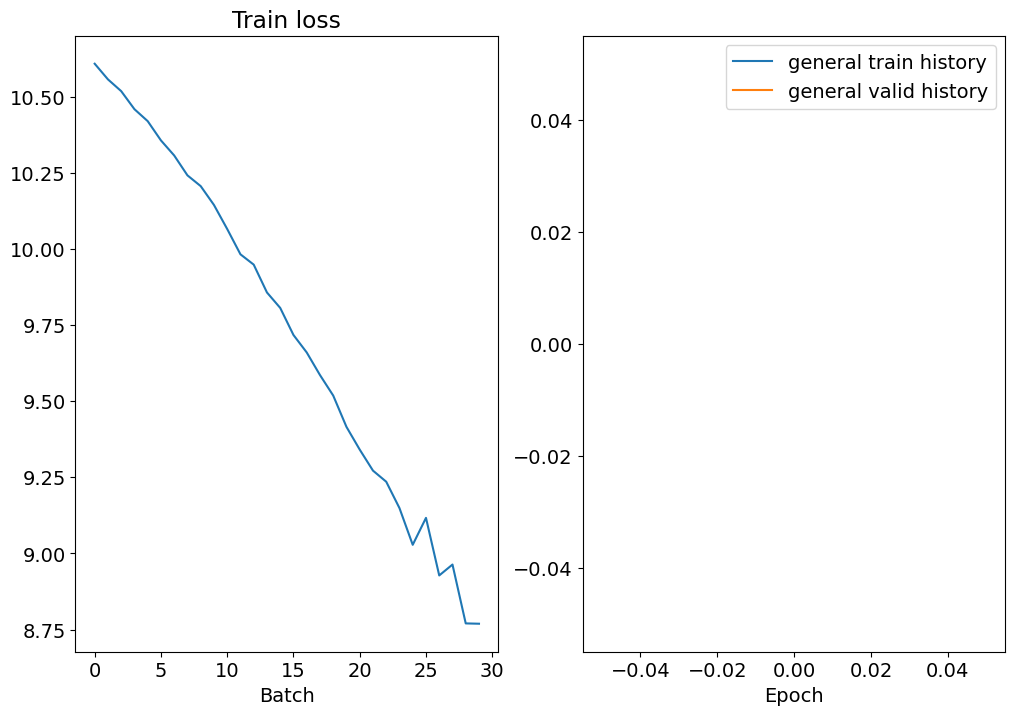

Досрочно остановлено пользователем


In [47]:
1
torchtext
HID_DIM = 256
ENC_LAYERS = 5
DEC_LAYERS = 5
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2


MODEL_NAME = '../models/transformer_baseline.pt'

train_eval_loop(model, train_iterator, valid_iterator, model_name=MODEL_NAME, N_EPOCHS=30)

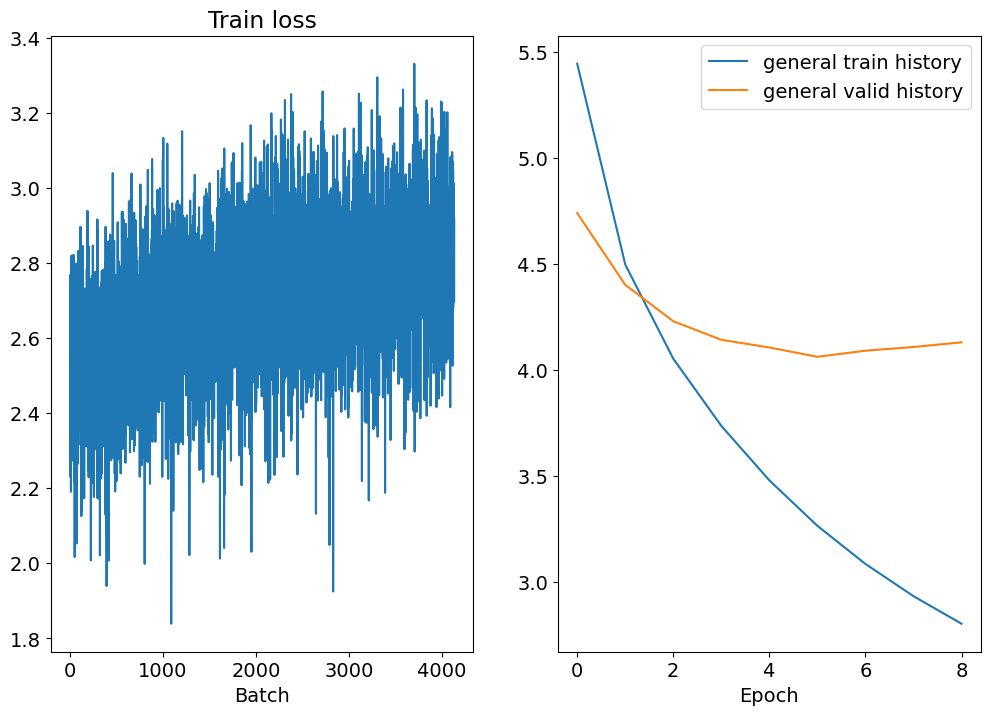

Epoch: 10 | Time: 4m 25s
	Train Loss: 2.693 | Train PPL:  14.774
	 Val. Loss: 4.150 |  Val. PPL:  63.426


In [34]:
2
torchtext
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1


MODEL_NAME = '../models/transformer_baseline.pt'

train_eval_loop(model, train_iterator, valid_iterator, model_name=MODEL_NAME, N_EPOCHS=10)

| Test Loss: 4.135 | Test PPL:  62.509 |

In [67]:
3
torchtext
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8


MODEL_NAME = '../models/transformer_baseline_do08.pt'

train_eval_loop(model, train_iterator, valid_iterator, model_name=MODEL_NAME, N_EPOCHS=30)

| Test Loss: 7.152 | Test PPL: 1277.153 |

Досрочно остановлено пользователем


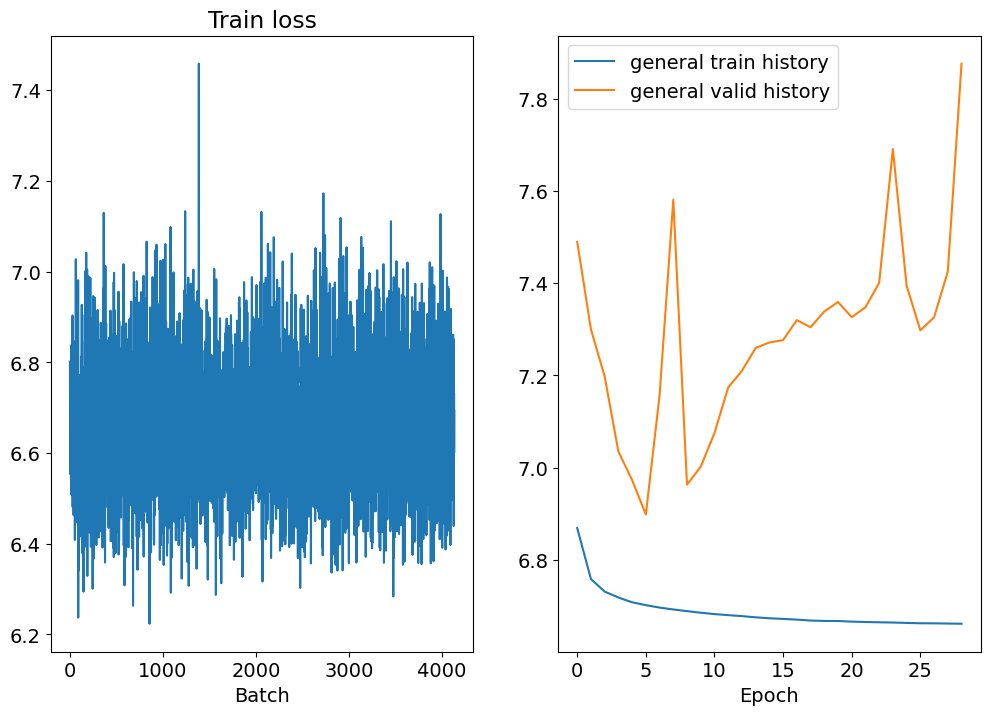

Epoch: 30 | Time: 4m 18s
	Train Loss: 6.662 | Train PPL: 782.434
	 Val. Loss: 7.651 |  Val. PPL: 2103.777


In [80]:
04
torchtext
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.4
DEC_DROPOUT = 0.4


MODEL_NAME = '../models/transformer_baseline_do04.pt'

train_eval_loop(model, train_iterator, valid_iterator, model_name=MODEL_NAME, N_EPOCHS=30)
| Test Loss: 6.931 | Test PPL: 1023.232 |

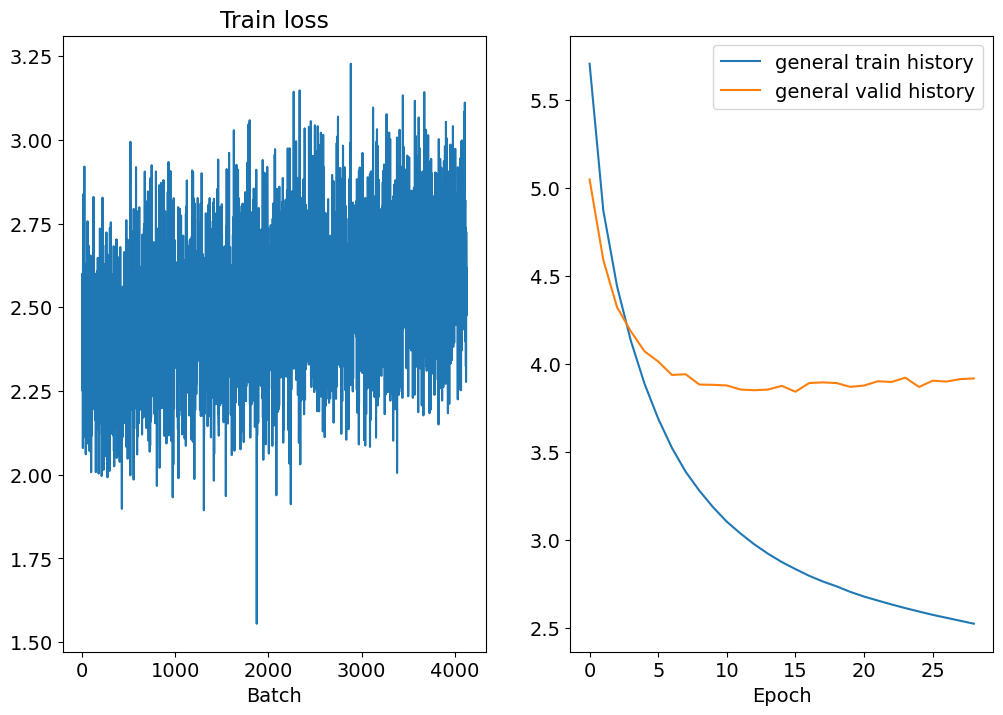

Epoch: 30 | Time: 4m 20s
	Train Loss: 2.513 | Train PPL:  12.346
	 Val. Loss: 3.942 |  Val. PPL:  51.522


In [95]:
torchtext
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2


MODEL_NAME = '../models/transformer_baseline_do02.pt'

train_eval_loop(model, train_iterator, valid_iterator, model_name=MODEL_NAME, N_EPOCHS=30)

| Test Loss: 3.929 | Test PPL:  50.865 |


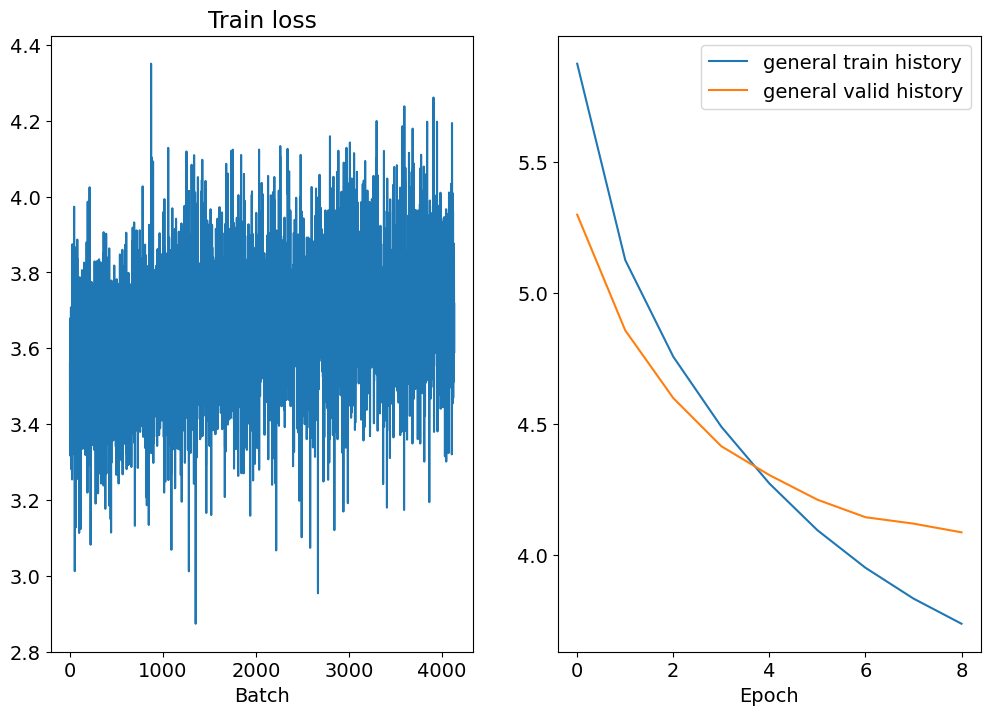

Epoch: 10 | Time: 4m 32s
	Train Loss: 3.662 | Train PPL:  38.929
	 Val. Loss: 4.065 |  Val. PPL:  58.263


In [34]:
torchtext
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3


MODEL_NAME = '../models/transformer_baseline_do03.pt'

train_eval_loop(model, train_iterator, valid_iterator, model_name=MODEL_NAME, N_EPOCHS=10)

| Test Loss: 4.131 | Test PPL:  62.242 |

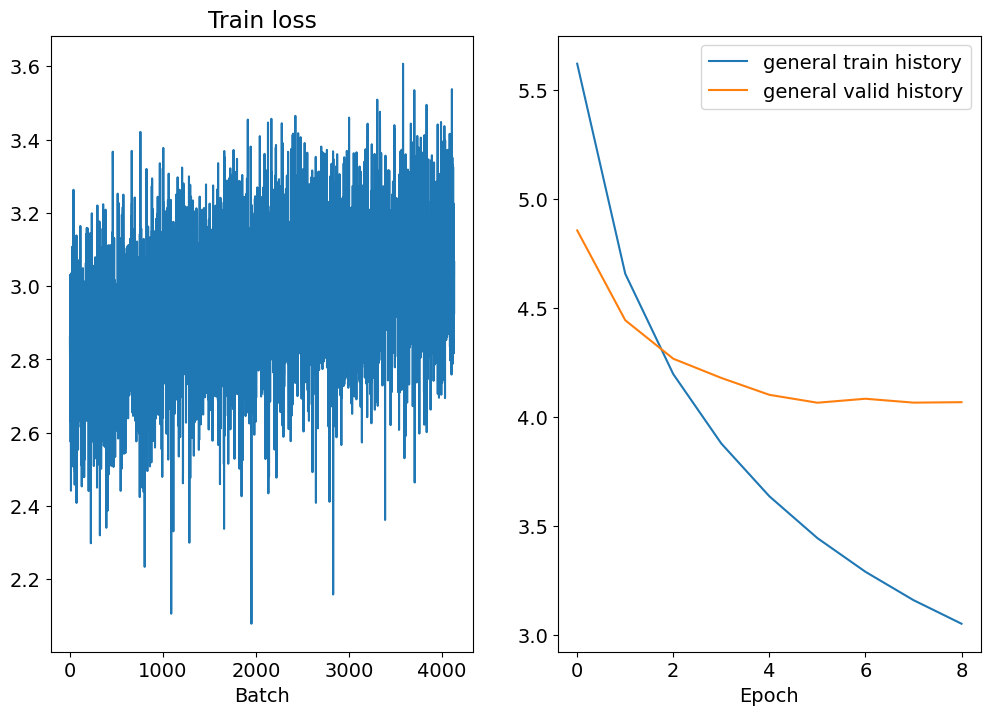

Epoch: 10 | Time: 4m 22s
	Train Loss: 2.959 | Train PPL:  19.280
	 Val. Loss: 4.065 |  Val. PPL:  58.288


In [34]:
'''torchtext
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 256
DEC_PF_DIM = 256
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2'''


MODEL_NAME = '../models/transformer_baseline.pt'

train_eval_loop(model, train_iterator, valid_iterator, model_name=MODEL_NAME, N_EPOCHS=10)

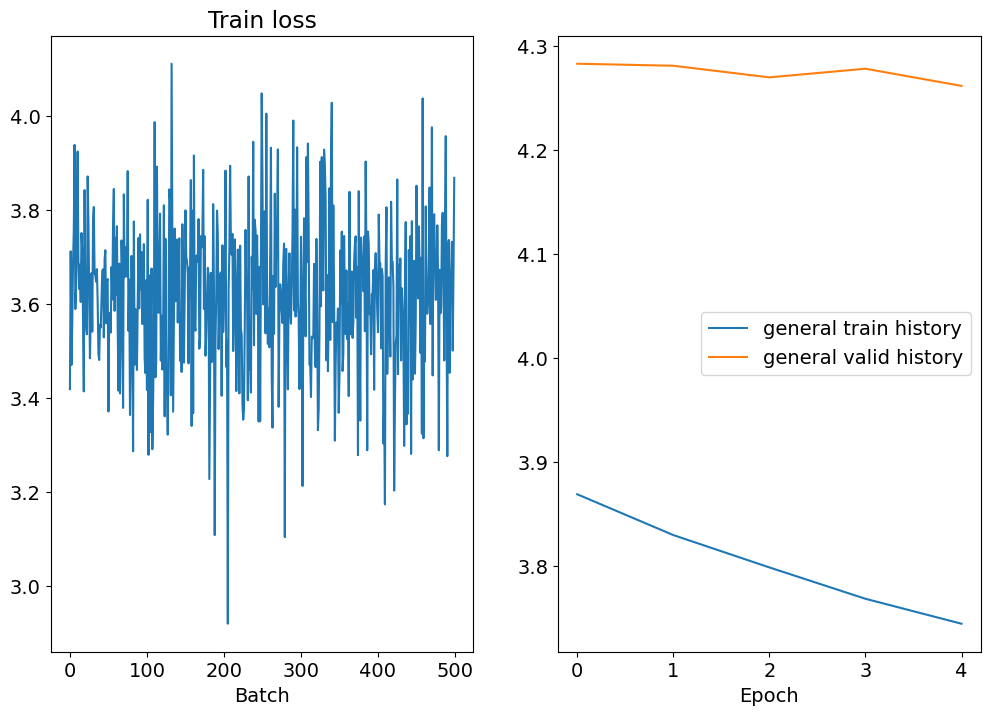

Досрочно остановлено пользователем


In [49]:
'''torchtext
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 256
DEC_PF_DIM = 256
ENC_DROPOUT = 0.4
DEC_DROPOUT = 0.4'''


MODEL_NAME = '../models/transformer_baseline.pt'

train_eval_loop(model, train_iterator, valid_iterator, model_name=MODEL_NAME, N_EPOCHS=10)

In [36]:
MODEL_NAME = '../models/transformer_baseline_do02.pt'

Finally, we load the parameters from our best validation loss and get our results on the test set.

In [50]:
#Мы загружаем наши «лучшие» параметры и добиваемся большей точности при тестировании, чем достигали все предыдущие модели.
model.load_state_dict(torch.load(MODEL_NAME))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.333 | Test PPL:  76.196 |


In [ ]:
'''# for cpu usage
if torch.cuda.is_available():
    model.load_state_dict(torch.load(MODEL_NAME))
# for gpu usage
else:
    model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')))


test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')'''

### Генерация заголовков

In [ ]:
def translate_sentence(model, tokenized_sentence):
    model.eval()
    tokenized_sentence = ['<sos>'] + [t.lower() for t in tokenized_sentence] + ['<eos>']
    numericalized = [TEXT.vocab.stoi[t] for t in tokenized_sentence] 
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [TEXT.vocab.itos[t] for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

In [38]:
def translate_sentence(sentence, voc, model, device, max_len = 50):
    
    model.eval()

    # режим генерации для токенизатора BPE
    bpe_mode = True if str(voc.__class__) == "<class 'youtokentome.youtokentome.BPE'>" else False
    
    # id токена конца последовательности
    eos_token_id = voc.subword_to_id('<eos>') if bpe_mode == True else voc.vocab.stoi['<eos>']       # сделать EOS

    if bpe_mode == True:
        src_numericalized = voc.encode(sentence, bos=True, eos=True)
    else:
        src_tokenized = ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']                  # сделать BOS и EOS
        src_numericalized = [voc.vocab.stoi[t] for t in src_tokenized] 
    
    src_tensor = torch.LongTensor(src_numericalized).unsqueeze(0).to(device) 
    
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    
    if bpe_mode == True:
        trg_indexes = [voc.subword_to_id('<sos>')]                  # сделать BOS 
    else:
        trg_indexes = [voc.vocab.stoi['<sos>']]                             # сделать BOS 
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            pred_token = output.argmax(2)[:,-1].item()
            trg_indexes.append(pred_token)
            
            if pred_token == eos_token_id:
                trg_indexes = trg_indexes[:-1]
                attention = attention[:, :, :-1, :]
                break 
    
    if bpe_mode == True:
        trg_tokens = voc.decode(trg_indexes[1:], ignore_ids=[2,3])
    else:
        trg_tokens = [voc.vocab.itos[i] for i in trg_indexes][1:]

    return trg_tokens, attention

#attention = translate_sentence(src, TEXT, model, device, max_len = 50)[1]

In [39]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(20,50))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy().T
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=12)
    ax.set_yticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'])
    ax.set_xticklabels(['']+translation, rotation=80)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [40]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(30,120))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy().T

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=10)
        ax.set_yticklabels(['']+['<BOS>']+[t.lower() for t in sentence]+['<EOS>'])
        ax.set_xticklabels(['']+translation, rotation=80)


        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [41]:
example_idx = 100

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['the', 'integrated', 'completed', 'likelihood', '(', 'icl', ')', 'criterion', 'has', 'proven', 'to', 'be', 'a', 'very', 'popular', 'approach', 'in', 'model', '-', 'based', 'clustering', 'through', 'automatically', 'choosing', 'the', 'number', 'of', 'clusters', 'in', 'a', 'mixture', 'model', '.', 'this', 'approach', 'effectively', 'maximises', 'the', 'complete', 'data', 'likelihood', ',', 'thereby', 'including', 'the', 'allocation', 'of', 'observations', 'to', 'clusters', 'in', 'the', 'model', 'selection', 'criterion', '.', 'however', 'for', 'practical', 'implementation', 'one', 'needs', 'to', 'introduce', 'an', 'approximation', 'in', 'order', 'to', 'estimate', 'the', 'icl', '.', 'our', 'contribution', 'here', 'is', 'to', 'illustrate', 'that', 'through', 'the', 'use', 'of', 'conjugate', 'priors', 'one', 'can', 'derive', 'an', 'exact', 'expression', 'for', 'icl', 'and', 'so', 'avoiding', 'any', 'approximation', '.', 'moreover', ',', 'we', 'illustrate', 'how', 'one', 'can', 'find',

In [42]:
translation, attention = translate_sentence(src, TEXT, model, device, max_len=50)

print(f'predicted trg = {translation}')

predicted trg = ['adaptive', 'model', 'selection', 'for', 'clustering', 'with', 'unknown', 'number', 'of', 'clusters']


C:\Temp\ipykernel_37180\3019165767.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['<BOS>']+[t.lower() for t in sentence]+['<EOS>'])
C:\Temp\ipykernel_37180\3019165767.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+translation, rotation=80)


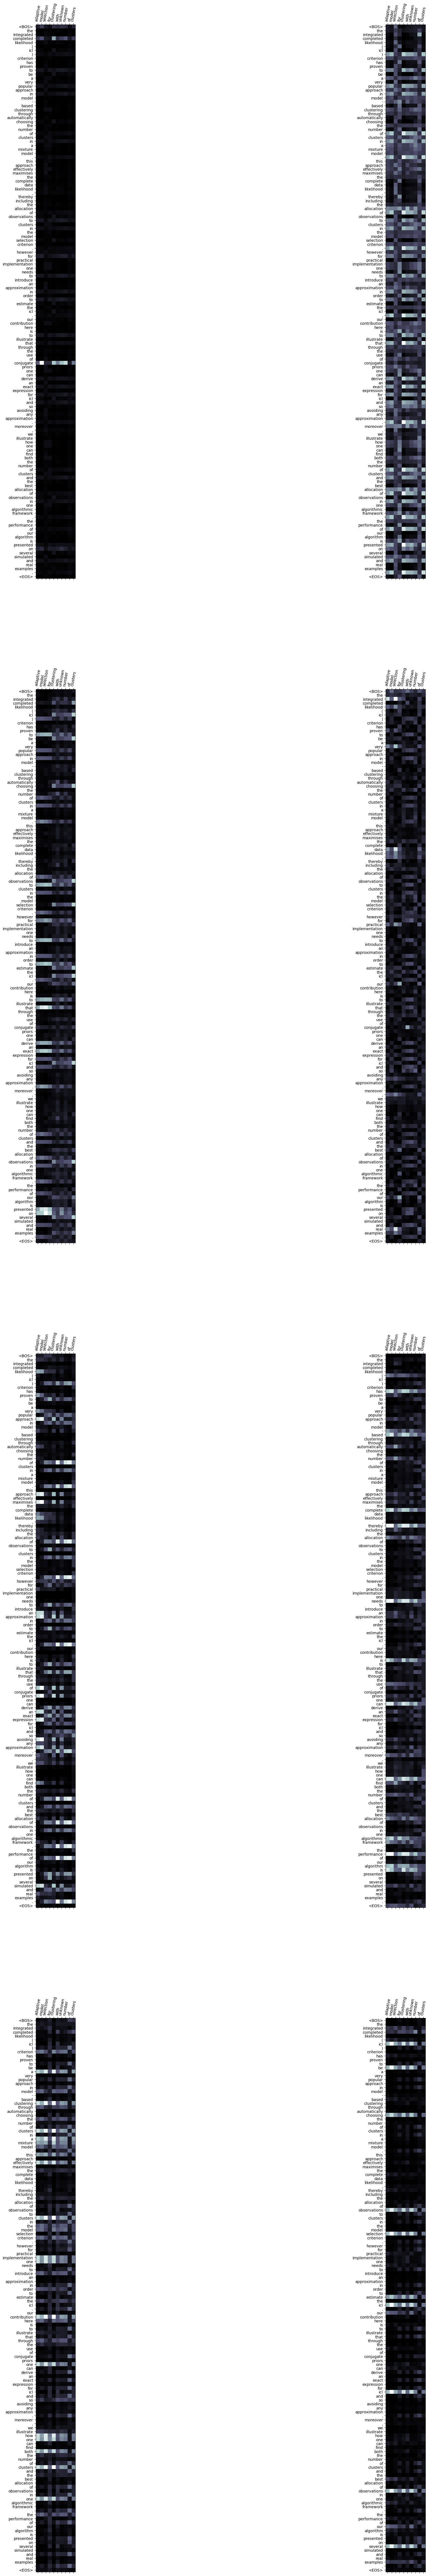

In [43]:
display_attention(src, translation, attention)

In [44]:
for example_idx in range(100):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(src, TEXT, model, device, max_len=50)

    print('Оригинальный заголовок: ', ' '.join(trg))
    print('Предсказанный заголовок: ', ' '.join(translation))
    print('-----------------------------------')

Оригинальный заголовок:  diversity and its decomposition into variety , balance and disparity
Предсказанный заголовок:  principal components analysis of urban area - level productivity analysis
-----------------------------------
Оригинальный заголовок:  improving the johnson - lindenstrauss lemma
Предсказанный заголовок:  a note on the lindeberg condition for mallows distance
-----------------------------------
Оригинальный заголовок:  the mean - field approximation model of company 's income growth
Предсказанный заголовок:  the income distribution of wealth distribution
-----------------------------------
Оригинальный заголовок:  efficient inference of protein structural ensembles
Предсказанный заголовок:  a computational model for protein folding
-----------------------------------
Оригинальный заголовок:  financial black swans driven by ultrafast machine ecology
Предсказанный заголовок:  the impact of climate change on the formation of isp - ott scaling in years years later
-------

In [45]:
example_idx = 0

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['suppose', 'a', 'string', '$', 'x_1^n=(x_1,x_2,', '...', ',x_n)$', 'generated', 'by', 'a', 'memoryless', 'source', '$', '(', 'x_n)_{n\\geq', '1}$', 'with', 'distribution', '$', 'p$', 'is', 'to', 'be', 'compressed', 'with', 'distortion', 'no', 'greater', 'than', '$', 'd\\geq', '0', '$', ',', 'using', 'a', 'memoryless', 'random', 'codebook', 'with', 'distribution', '$', 'q$.', 'the', 'compression', 'performance', 'is', 'determined', 'by', 'the', '`', '`', 'generalized', 'asymptotic', 'equipartition', 'property', "''", '(', 'aep', ')', ',', 'which', 'states', 'that', 'the', 'probability', 'of', 'finding', 'a', '$', 'd$-close', 'match', 'between', '$', 'x_1^n$', 'and', 'any', 'given', 'codeword', '$', 'y_1^n$', ',', 'is', 'approximately', '$', '2^{-n', 'r(p', ',', 'q', ',', 'd)}$', ',', 'where', 'the', 'rate', 'function', '$', 'r(p', ',', 'q', ',', 'd)$', 'can', 'be', 'expressed', 'as', 'an', 'infimum', 'of', 'relative', 'entropies', '.', 'the', 'main', 'purpose', 'here', 'is', 'to'

In [46]:
translation, attention = translate_sentence(src, TEXT, model, device, max_len=50)

print(f'predicted trg = {translation}')

#display_attention(src, translation, attention)

predicted trg = ['compression', 'of', 'random', 'fields']


In [47]:
example_idx = 510

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['we', 'present', 'a', 'bayesian', 'hierarchical', 'framework', 'for', 'both', 'cross', '-', 'sectional', 'and', 'time', '-', 'series', 'return', 'prediction', '.', 'our', 'approach', 'builds', 'on', 'a', 'market', '-', 'timing', 'predictive', 'system', 'that', 'jointly', 'allows', 'for', 'time', '-', 'varying', 'coefficients', 'driven', 'by', 'fundamental', 'characteristics', '.', 'with', 'a', 'bayesian', 'formulation', 'for', 'ensemble', 'learning', ',', 'we', 'examine', 'the', 'joint', 'predictability', 'as', 'well', 'as', 'portfolio', 'efficiency', 'via', 'predictive', 'distribution', '.', 'in', 'the', 'empirical', 'analysis', 'of', 'asset', '-', 'sector', 'allocation', ',', 'our', 'hierarchical', 'ensemble', 'learning', 'portfolio', 'achieves', '500', '%', 'cumulative', 'returns', 'in', 'the', 'period', '1998', '-', '2017', ',', 'and', 'outperforms', 'most', 'workhorse', 'benchmarks', 'as', 'well', 'as', 'the', 'passive', 'investing', 'index', '.', 'our', 'bayesian', 'infere

In [48]:
translation, attention = translate_sentence(src, TEXT, model, device, max_len=50)

print(f'predicted trg = {translation}')

#display_attention(src, translation, attention)

predicted trg = ['bayesian', 'learning', 'of', 'dynamic', 'portfolio', 'predictors']


### Считаем BLEU на train.csv

In [49]:
import nltk

n_gram_weights = [0.3334, 0.3333, 0.3333]

In [50]:
test_len = len(test_data)

In [51]:
original_texts = []
generated_texts = []
macro_bleu = 0

for example_idx in range(test_len):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, _ = translate_sentence(src, TEXT, model, device, max_len=50)

    original_texts.append(trg)
    generated_texts.append(translation)

    bleu_score = nltk.translate.bleu_score.sentence_bleu(
        [trg],
        translation,
        weights = n_gram_weights
    )    
    macro_bleu += bleu_score

macro_bleu /= test_len

c:\Users\denis\anaconda3\envs\python_3.8\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\denis\anaconda3\envs\python_3.8\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [52]:
# averaging sentence-level BLEU (i.e. macro-average precision)
print('Macro-average BLEU (Transformer): {0:.5f}'.format(macro_bleu))

Macro-average BLEU (Transformer): 0.01536


### Делаем submission в Kaggle

In [156]:
import pandas as pd

submission_data = pd.read_csv('../datasets/Arxiv_Title_Generation/test.csv')
abstracts = submission_data['abstract'].values

Генерация заголовков для тестовых данных:

In [157]:
titles = []
for abstract in abstracts:
    title, _ = translate_sentence(model, abstract.split())
    titles.append(' '.join(title).replace('<unk>', ''))

Записываем полученные заголовки в файл формата `<abstract>,<title>`:

In [158]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('../datasets/Arxiv_Title_Generation/predicted_titles.csv', index=False)

С помощью скрипта `generate_csv` приводим файл `submission_prediction.csv` в формат, необходимый для посылки в соревнование на Kaggle:

In [159]:
from create_submission import generate_csv

generate_csv('../datasets/Arxiv_Title_Generation/predicted_titles.csv', '../datasets/Arxiv_Title_Generation/kaggle_pred.csv', '../datasets/Arxiv_Title_Generation/vocs.pkl')

In [160]:
!wc -l ../datasets/Arxiv_Title_Generation/kaggle_pred.csv

  343443 ../datasets/Arxiv_Title_Generation/kaggle_pred.csv


In [161]:
!head ../datasets/Arxiv_Title_Generation/kaggle_pred.csv

Id,Predict
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0


# Генерация заголовков с использованием BeamSearch

In [83]:
import heapq
import numpy as np

class BeamGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.bpe_mode = True if str(tokenizer.__class__) == "<class 'youtokentome.youtokentome.BPE'>" else False
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id                                                                                #
        self.eos_token_id = self.tokenizer.subword_to_id('<eos>') if self.bpe_mode == True else self.tokenizer.vocab.stoi['<eos>']      # EOS

    def __call__(self, src_tokenized, max_steps_n=40, return_hypotheses_n=5, beamsize=5):

        # токенизация текста    
        if self.bpe_mode == True:
            src_numericalized = self.SRC.encode(' '.join(sentence), bos=True, eos=True)
        else:
            src_tokenized = ['<sos>'] + [t.lower() for t in src_tokenized] + ['<eos>']      # '<BOS>' '<EOS>'
            src_numericalized = [self.tokenizer.vocab.stoi[t] for t in src_tokenized] 
            
        src_tensor = torch.LongTensor(src_numericalized).unsqueeze(0).to(device) 
        src_mask = model.make_src_mask(src_tensor)

        self.model.eval()

        with torch.no_grad():
            enc_src = self.model.encoder(src_tensor, src_mask)

        if self.bpe_mode == True:
            trg_indexes = [self.tokenizer.subword_to_id('<sos>')]    # '<BOS>'
        else:
            trg_indexes = [self.tokenizer.vocab.stoi['<sos>']]        # '<BOS>'
        
        partial_hypotheses = [(0, trg_indexes, None)] # список промежуточных гипотез (очередь из веса и гипотезы)
        final_hypotheses = []                           # список готовых гипотез     

        while (len(partial_hypotheses) > 0):                    

            cur_partial_score, cur_partial_hypothesis, _ = heapq.heappop(partial_hypotheses)   # очередь с приоритетами

            # для текущей гипотезы предсказывается следующий токен
            #in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)  = trg_tensor
            trg_tensor = torch.LongTensor(cur_partial_hypothesis).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)

            # для текущей гипотезы предсказывается следующий токен
            with torch.no_grad():
                output, attention = self.model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
                #next_tokens_logits = self.model(in_batch)[0, -1] = output
                # нормирование логитов (логарифмически для сглаживания отдельных маленьких вероятностей - сумма вместо произведения)
                next_tokens_logproba = F.log_softmax(output[0, -1],dim=0)
                
                #pred_token = output.argmax(2)[:,-1].item()

                # выбор k токенов с наибольшей вероятностью
                temp_next_tokens_logproba = next_tokens_logproba
                topk_continuations = next_tokens_logproba.topk(beamsize)

                # итерация по списку k лучших вариантов
                for token_score, token_idx in zip(topk_continuations.values, topk_continuations.indices):

                    token_score = float(token_score)    # отбрасывание объектов pytorch
                    token_idx = int(token_idx)          # отбрасывание объектов pytorch

                    # рассчет новой оценки правдоподобности гипотезы с нормализацией по длине последовательности
                    old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                    new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hypothesis) + 1)

                    # к гипотезе дописывается токен
                    new_hypothesis = cur_partial_hypothesis + [token_idx]
                    new_item = (new_score, new_hypothesis, attention)

                    if token_idx == (self.eos_token_id) or ((len(new_hypothesis) - 2) >= max_steps_n):
                        final_hypotheses.append(new_item)
                    else:
                        heapq.heappush(partial_hypotheses, new_item)    # гипотеза кладется в очередь

                # очередь обрезается по длине beamsize
                if len(partial_hypotheses) > beamsize:
                    partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                    heapq.heapify(partial_hypotheses)

        final_hypotheses.sort()
        final_hypotheses = final_hypotheses[:return_hypotheses_n]

        final_scores, final_token_lists, attentions = zip(*final_hypotheses)


        if self.bpe_mode == True:
            # разбиваем предикт на токены для визуализации на графике
            trg_tokens = []
            for hypothesis in final_token_lists:
                trg_tokens.append(self.tokenizer.decode([[token] for token in hypothesis][1:]))                 # разобраться с attention
            trg_tokens = tuple(trg_tokens)
            #trg_tokens = tuple(self.TRG.decode(hypothesis[1:]) for hypothesis in final_token_lists)
        else:
            #trg_tokens = []
            #for hypothesis in final_token_lists:
            #    trg_tokens.append([self.tokenizer.vocab.itos[i] for i in hypothesis[1:]])
            #trg_tokens = tuple(trg_tokens)

            trg_tokens = []
            attentions_temp = []

            for i in range(len(final_token_lists)):
                if final_token_lists[i][-1] == 3:
                    trg_tokens.append([self.tokenizer.vocab.itos[i] for i in final_token_lists[i][1:-1]])
                    attentions_temp.append(attentions[i][:, :, :-1, :])
                    #print(len([self.tokenizer.vocab.itos[i] for i in final_token_lists[i][1:-1]]))
                    #print([self.tokenizer.vocab.itos[i] for i in final_token_lists[i][1:-1]])
                    #print(attentions[i][:, :, :-1, :].shape)
                else:
                    trg_tokens.append([self.tokenizer.vocab.itos[i] for i in final_token_lists[i][1:]])
                    attentions_temp.append(attentions[i])

            trg_tokens = tuple(trg_tokens)
            attentions = tuple(attentions_temp)



            
            #if pred_token == eos_token_id:
            #    trg_indexes = trg_indexes[:-1]
            #    attention = attention[:, :, :-1, :]
            #    break 
    
        '''if bpe_mode == True:
            trg_tokens = voc.decode(trg_indexes[1:], ignore_ids=[2,3])
        else:
            trg_tokens = [voc.vocab.itos[i] for i in trg_indexes][1:]

        return trg_tokens, attention'''



        #attentions = tuple(i[1:] for i in attentions)

        result = list(zip(final_scores, trg_tokens, attentions))
        return result
        
    
beam_generator = BeamGenerator(model, TEXT, device=device)

beam_gen_variants = beam_generator(src,
                                   max_steps_n=40,
                                   beamsize=20,
                                   return_hypotheses_n=1)
beam_gen_variants[0]

(2.2555473176468306,
 ['deep',
  'reinforcement',
  'learning',
  'for',
  'maneuver',
  'searching',
  'in',
  'uav',
  'networks'],
 tensor([[[[1.1578e-02, 6.9703e-04, 6.2066e-04,  ..., 6.5287e-04,
            1.2668e-03, 1.5517e-04],
           [1.1299e-02, 6.3323e-04, 5.4414e-04,  ..., 5.7959e-04,
            5.5523e-04, 3.6550e-05],
           [5.2796e-03, 4.3519e-04, 3.8478e-04,  ..., 4.0160e-04,
            2.6121e-03, 2.0593e-04],
           ...,
           [9.6381e-03, 1.7461e-03, 1.6588e-03,  ..., 1.7059e-03,
            8.9034e-03, 1.0631e-03],
           [1.8886e-02, 6.0926e-03, 5.5501e-03,  ..., 5.7933e-03,
            1.0084e-03, 1.4721e-04],
           [7.5133e-03, 8.2081e-04, 7.8975e-04,  ..., 8.0735e-04,
            1.5905e-03, 3.9975e-04]],
 
          [[1.6507e-03, 1.1940e-02, 1.1085e-02,  ..., 1.0758e-02,
            6.5016e-03, 9.7363e-04],
           [1.7330e-03, 1.2432e-02, 1.1127e-02,  ..., 1.0811e-02,
            7.6550e-03, 3.1563e-04],
           [9.6239e-03,

In [84]:
beam_generator = BeamGenerator(model, TEXT, device=device)

beam_gen_variants = beam_generator(src,
                                   max_steps_n=40,
                                   beamsize=20,
                                   return_hypotheses_n=1)
beam_gen_variants[0][1]

['deep',
 'reinforcement',
 'learning',
 'for',
 'maneuver',
 'searching',
 'in',
 'uav',
 'networks']

In [85]:
example_idx = 100

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['the', 'integrated', 'completed', 'likelihood', '(', 'icl', ')', 'criterion', 'has', 'proven', 'to', 'be', 'a', 'very', 'popular', 'approach', 'in', 'model', '-', 'based', 'clustering', 'through', 'automatically', 'choosing', 'the', 'number', 'of', 'clusters', 'in', 'a', 'mixture', 'model', '.', 'this', 'approach', 'effectively', 'maximises', 'the', 'complete', 'data', 'likelihood', ',', 'thereby', 'including', 'the', 'allocation', 'of', 'observations', 'to', 'clusters', 'in', 'the', 'model', 'selection', 'criterion', '.', 'however', 'for', 'practical', 'implementation', 'one', 'needs', 'to', 'introduce', 'an', 'approximation', 'in', 'order', 'to', 'estimate', 'the', 'icl', '.', 'our', 'contribution', 'here', 'is', 'to', 'illustrate', 'that', 'through', 'the', 'use', 'of', 'conjugate', 'priors', 'one', 'can', 'derive', 'an', 'exact', 'expression', 'for', 'icl', 'and', 'so', 'avoiding', 'any', 'approximation', '.', 'moreover', ',', 'we', 'illustrate', 'how', 'one', 'can', 'find',

predicted GreedyTranslator trg = ['adaptive', 'model', 'selection', 'for', 'clustering', 'with', 'unknown', 'number', 'of', 'clusters']
predicted BeamTranslator trg =   ['post', '-', 'selection', 'inference', 'for', 'model', '-', 'based', 'clustering']



C:\Temp\ipykernel_37180\3019165767.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['<BOS>']+[t.lower() for t in sentence]+['<EOS>'])
C:\Temp\ipykernel_37180\3019165767.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+translation, rotation=80)


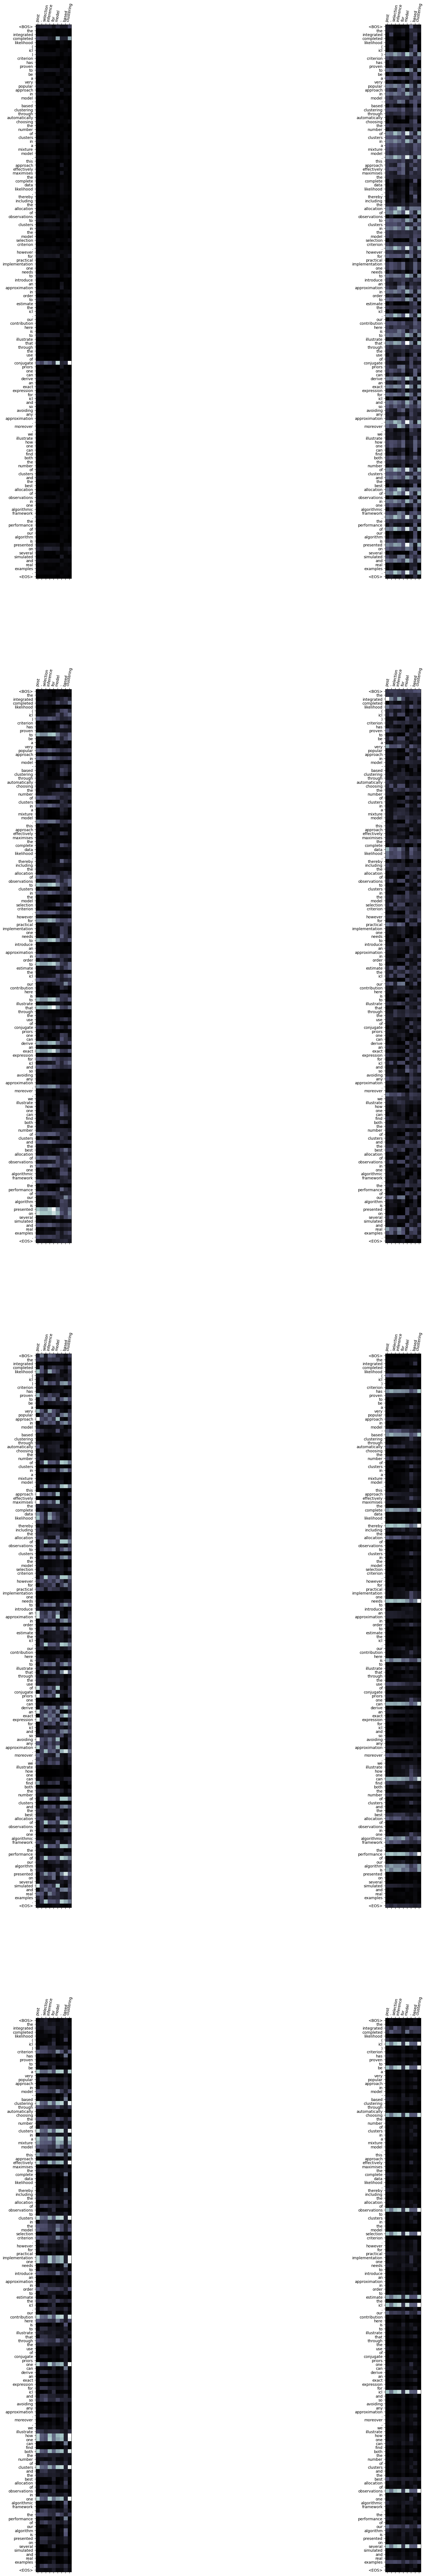

In [86]:
translation, _ = translate_sentence(src, TEXT, model, device, max_len=50)
print(f'predicted GreedyTranslator trg = {translation}')

_, translation, attention = beam_generator(src, max_steps_n=40, beamsize=20, return_hypotheses_n=1)[0]
print(f'predicted BeamTranslator trg =   {translation}')
print()

display_attention(src, translation, attention)

In [87]:
for example_idx in range(100):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation_greedy, _ = translate_sentence(src, TEXT, model, device, max_len=50)
    _, translation_beamsearch, _ = beam_generator(src, max_steps_n=40, beamsize=20, return_hypotheses_n=1)[0]

    print('Оригинальный заголовок:                     ', ' '.join(trg))
    print('Предсказанный заголовок (жадная генерация): ', ' '.join(translation_greedy))
    print('Предсказанный заголовок (лучевой поиск):    ', ' '.join(translation_beamsearch))
    print('-----------------------------------')

Оригинальный заголовок:                      diversity and its decomposition into variety , balance and disparity
Предсказанный заголовок (жадная генерация):  principal components analysis of urban area - level productivity analysis
Предсказанный заголовок (лучевой поиск):     archetypal athletes
-----------------------------------
Оригинальный заголовок:                      improving the johnson - lindenstrauss lemma
Предсказанный заголовок (жадная генерация):  a note on the lindeberg condition for mallows distance
Предсказанный заголовок (лучевой поиск):     computing the bergsma dassios sign - covariance
-----------------------------------
Оригинальный заголовок:                      the mean - field approximation model of company 's income growth
Предсказанный заголовок (жадная генерация):  the income distribution of wealth distribution
Предсказанный заголовок (лучевой поиск):     the distribution of income distribution
-----------------------------------
Оригинальный заголовок:  

In [90]:
example_idx = 0

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['suppose', 'a', 'string', '$', 'x_1^n=(x_1,x_2,', '...', ',x_n)$', 'generated', 'by', 'a', 'memoryless', 'source', '$', '(', 'x_n)_{n\\geq', '1}$', 'with', 'distribution', '$', 'p$', 'is', 'to', 'be', 'compressed', 'with', 'distortion', 'no', 'greater', 'than', '$', 'd\\geq', '0', '$', ',', 'using', 'a', 'memoryless', 'random', 'codebook', 'with', 'distribution', '$', 'q$.', 'the', 'compression', 'performance', 'is', 'determined', 'by', 'the', '`', '`', 'generalized', 'asymptotic', 'equipartition', 'property', "''", '(', 'aep', ')', ',', 'which', 'states', 'that', 'the', 'probability', 'of', 'finding', 'a', '$', 'd$-close', 'match', 'between', '$', 'x_1^n$', 'and', 'any', 'given', 'codeword', '$', 'y_1^n$', ',', 'is', 'approximately', '$', '2^{-n', 'r(p', ',', 'q', ',', 'd)}$', ',', 'where', 'the', 'rate', 'function', '$', 'r(p', ',', 'q', ',', 'd)$', 'can', 'be', 'expressed', 'as', 'an', 'infimum', 'of', 'relative', 'entropies', '.', 'the', 'main', 'purpose', 'here', 'is', 'to'

In [91]:
translation, _ = translate_sentence(src, TEXT, model, device, max_len=50)
print(f'predicted GreedyTranslator trg = {translation}')

_, translation, attention = beam_generator(src, max_steps_n=40, beamsize=20, return_hypotheses_n=1)[0]
print(f'predicted BeamTranslator trg =   {translation}')
print()

#display_attention(src, translation, attention)

predicted GreedyTranslator trg = ['compression', 'of', 'random', 'fields']
predicted BeamTranslator trg =   ['compression', 'and', 'multiparty', 'squashed', 'entanglement']



In [92]:
example_idx = 510

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['we', 'present', 'a', 'bayesian', 'hierarchical', 'framework', 'for', 'both', 'cross', '-', 'sectional', 'and', 'time', '-', 'series', 'return', 'prediction', '.', 'our', 'approach', 'builds', 'on', 'a', 'market', '-', 'timing', 'predictive', 'system', 'that', 'jointly', 'allows', 'for', 'time', '-', 'varying', 'coefficients', 'driven', 'by', 'fundamental', 'characteristics', '.', 'with', 'a', 'bayesian', 'formulation', 'for', 'ensemble', 'learning', ',', 'we', 'examine', 'the', 'joint', 'predictability', 'as', 'well', 'as', 'portfolio', 'efficiency', 'via', 'predictive', 'distribution', '.', 'in', 'the', 'empirical', 'analysis', 'of', 'asset', '-', 'sector', 'allocation', ',', 'our', 'hierarchical', 'ensemble', 'learning', 'portfolio', 'achieves', '500', '%', 'cumulative', 'returns', 'in', 'the', 'period', '1998', '-', '2017', ',', 'and', 'outperforms', 'most', 'workhorse', 'benchmarks', 'as', 'well', 'as', 'the', 'passive', 'investing', 'index', '.', 'our', 'bayesian', 'infere

In [94]:
translation, _ = translate_sentence(src, TEXT, model, device, max_len=50)
print(f'predicted GreedyTranslator trg = {translation}')

_, translation, attention = beam_generator(src, max_steps_n=40, beamsize=20, return_hypotheses_n=1)[0]
print(f'predicted BeamTranslator trg =   {translation}')
print()

#display_attention(src, translation, attention)

predicted GreedyTranslator trg = ['bayesian', 'learning', 'of', 'dynamic', 'portfolio', 'predictors']
predicted BeamTranslator trg =   ['dynamic', 'portfolio', 'selection']



### Считаем BLEU на train.csv

In [95]:
import nltk

n_gram_weights = [0.3334, 0.3333, 0.3333]

In [96]:
test_len = len(test_data)

In [97]:
original_texts = []
generated_texts = []
macro_bleu = 0

for example_idx in range(test_len):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    _, translation, attention = beam_generator(src, max_steps_n=40, beamsize=20, return_hypotheses_n=1)[0]

    original_texts.append(trg)
    generated_texts.append(translation)

    bleu_score = nltk.translate.bleu_score.sentence_bleu(
        [trg],
        translation,
        weights = n_gram_weights
    )    
    macro_bleu += bleu_score

macro_bleu /= test_len

c:\Users\denis\anaconda3\envs\python_3.8\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\denis\anaconda3\envs\python_3.8\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [98]:
# averaging sentence-level BLEU (i.e. macro-average precision)
print('Macro-average BLEU (Transformer): {0:.5f}'.format(macro_bleu))

Macro-average BLEU (Transformer): 0.01935


In [ ]:
bs 5
на 10 - 0.02194
на 15 - 0.02167
на 20 - 0.02171
на 40 - 0.02173

bs 10
на 10 - 0.02023
на 15 - 0.02018
на 20 - 0.02026
на 40 - 0.02028

In [ ]:
0.02193

### Делаем submission в Kaggle

In [99]:
import pandas as pd

submission_data = pd.read_csv('../datasets/Arxiv_Title_Generation/test.csv')
abstracts = submission_data['abstract'].values

Генерация заголовков для тестовых данных:

In [101]:
titles = []
for abstract in abstracts:
    _, title, _ = beam_generator(src, max_steps_n=40, beamsize=20, return_hypotheses_n=1)[0]
    titles.append(' '.join(title).replace('<unk>', ''))

Записываем полученные заголовки в файл формата `<abstract>,<title>`:

In [102]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('../datasets/Arxiv_Title_Generation/predicted_titles.csv', index=False)

С помощью скрипта `generate_csv` приводим файл `submission_prediction.csv` в формат, необходимый для посылки в соревнование на Kaggle:

In [103]:
from create_submission import generate_csv

generate_csv('../datasets/Arxiv_Title_Generation/predicted_titles.csv', '../datasets/Arxiv_Title_Generation/kaggle_pred.csv', '../datasets/Arxiv_Title_Generation/vocs.pkl')

In [ ]:
torchtext


## Итоги (Score):
- Transformer (HID_DIM=256, LAYERS=3, HEADS=8, PF_DIM=512, DROPOUT=0.2) + BeamSearch (max_steps_n=40, beamsize=20): 0.08236
